In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
device = torch.device("cpu")# torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.preprocessing import OneHotEncoder
import matplotlib.animation as animation
from IPython.display import HTML
from misc_tools.print_latex import print_tex

input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

## 1) Import dataset (Cora citation network $\rightarrow$ graph).
<i>The Cora dataset consists of 2708 scientific publications classified into one of seven classes.<br>The citation network consists of 5429 links.<br>
Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.<br>
The dictionary consists of 1433 unique words.</i><br>
https://graphsandnetworks.com/the-cora-dataset/

### For purpose of model validation split whole dataset in two.
I want to use build-in features for dataset splitting, but for semi-supervised learning meaning of train, test, validation subsets are skewed.

Masks:
* train - these features will be available for semi-supervised learning. Rename to `mask_features`
* test - large portion of nodes that will exchange features
* validation - completely isolated graph for validation model

We have to join train and test masks into `masks_train`, so unmasked nodes are on one graph.

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import os
torch.manual_seed(69)
num_train_per_class = 20
dataset = Planetoid(    root=os.path.join('data_processing','neural_networks', 'data', 'Planetoid'),
                        name='Cora', 
                        transform=NormalizeFeatures(),
                        split = 'random',
                        num_test= 1000 - 7*num_train_per_class, # to combine into 1000 entries
                        num_val = 500,
                        num_train_per_class= num_train_per_class)
print(f'{dataset.num_features = }, {dataset.num_classes = }')
print(dataset._data)


mask_train      = torch.bitwise_or(dataset.train_mask, dataset.test_mask).bool()

mask_validate = dataset.val_mask.bool()

print('validation and train masks overlap: ', torch.bitwise_and(mask_validate, mask_train).sum().bool().item())

dataset.num_features = 1433, dataset.num_classes = 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
validation and train masks overlap:  False


## 2) Create a custom GAT Layer
Heavily based on https://nn.labml.ai/graphs/gat/index.html, but follows conventions from my notes (./GNN_Attention_notes.ipynb) + extra stuff.

In [3]:
class GraphAttentionLayer(nn.Module):
    def __init__(self, N_FEATURES, N_HEADS, N_HIDDEN, non_lin, mask_attention = True, concat: bool = False, l_ReLU_slope: float = 0.2, dropout: float = 0.6, dtype = torch.float):
        super(GraphAttentionLayer, self).__init__()
        # 1) globals
        self.mask_attention = mask_attention
        self.N_FEATURES, self.N_HEADS,  self.N_HIDDEN  = N_FEATURES, N_HEADS, N_HIDDEN
        self.concat = concat
        self.dtype = dtype
        # 2) weights 
        # 2.1) project H0 to G      [N_nodes x N_features] -> [N_nodes x N_hidden]
        self.W_gh   = nn.Linear(in_features=N_FEATURES, out_features=N_HEADS*N_HIDDEN, bias=False, dtype=dtype)
        # 2.2) project Ck to alpha  [N_nodes x N_nodes x N_heads x N_features] -> [N_nodes x N_hidden x N_heads]
        self.attention  = nn.Parameter(torch.empty(size=(2*N_HIDDEN, N_HEADS), dtype=dtype))
        nn.init.xavier_uniform_(self.attention) 

        # misc processing
        self.activ_alpha    = nn.LeakyReLU(l_ReLU_slope)
        self.softmax        = nn.Softmax(dim = 1)
        self.activ_Gn_new   = non_lin
        self.dropout        = nn.Dropout(dropout)

    def forward(self, A, H):
        H = H.to(self.dtype)
        N_NODES = H.size(0)
        N_HEADS, N_HIDDEN = self.N_HEADS,  self.N_HIDDEN
        # 1) Get features
        Gk_reshaped = self.W_gh(H).view(N_NODES, N_HEADS, N_HIDDEN)
        # 2) Prepare attention/adjacency matrix
        # 2.1) Concatenated pairwise features for each head
        C_left  = Gk_reshaped.repeat_interleave(N_NODES, dim=0)
        C_right = Gk_reshaped.repeat(N_NODES, 1, 1)
        Ck      = torch.cat([C_left, C_right], dim=-1).view(N_NODES, N_NODES, N_HEADS, 2*N_HIDDEN)
        # 2.2) Project concat features to a scalar
        alpha   = self.activ_alpha(torch.einsum('ijkf,fk -> ijk', Ck, self.attention)).view(N_NODES, N_NODES, N_HEADS)
        # 2.3) Apply adjacency matrix mask, softmax and dropout
        if self.mask_attention:
            alpha.masked_fill_(A.reshape(N_NODES,N_NODES,1) == 0, float('-inf'))
        alpha = self.softmax(alpha)
        alpha = self.dropout(alpha)
        # 3) Calculate new feature vectors by aggregation, using attention matrix.
        Gk_new = torch.einsum('ijk,jkf->ikf', alpha , Gk_reshaped)
        # 4) Additional processing. Like in paper, its either mean or concat, with activation.
        if self.concat:
            # activation before concat
            Gk_new = self.activ_Gn_new(Gk_new)
            return Gk_new.reshape(N_NODES, N_HEADS * N_HIDDEN)
        else:
            # activation after
            Gk_new = Gk_new.mean(dim=1).view(N_NODES, 1, N_HIDDEN)
            return self.activ_Gn_new(Gk_new)

## 3) Recreate NN model based on GAT paper:
Model paramters from OG paper https://arxiv.org/pdf/1710.10903.pdf

Transductive learning.

1. GAT layers = 2<br>
    1. Layer 1<br>
            1. N_HEADS = 8 <br>
            2. N_HIDDEN = 8 <br>
            3. activation = ELU <br>
            4. concatenation = True <br>
            5. N_FEATURES = original number
    2. Layer 2<br>
        1. N_HEADS = 1 <br>
        2. N_HIDDEN = number of classes <br>
        3. activation = SoftMax <br>
        4. concatenation = false <br>
        5. N_FEATURES = Layer 1 N_HEADS * layer 1 N_HIDDEN
2. regularization = $L_2$, scale = 0.0005 >>> not yet implemented, idk if needed
3. dropout, p = 0.6



In [4]:
class net(nn.Module):
    def __init__(self, N_FEATURES, N_HEADS, N_HIDDEN, dropout = 0.1):
        super(net, self).__init__()
        N_FEATURES_1, N_FEATURES_2  = N_FEATURES
        N_HEADS_1   , N_HEADS_2     = N_HEADS
        N_HIDDEN_1  , N_HIDDEN_2    = N_HIDDEN

        self.dropout = nn.Dropout(dropout)
        
        self.GAT1 = GraphAttentionLayer(N_FEATURES_1, N_HEADS_1, N_HIDDEN_1, 
                                        nn.ELU()           , mask_attention = True, concat = True , dropout = dropout)
        self.GAT2 = GraphAttentionLayer(N_FEATURES_2, N_HEADS_2, N_HIDDEN_2, 
                                        nn.Softmax(dim = 2), mask_attention = True, concat = False, dropout = dropout)

    def forward(self, A, H):
        x = self.dropout(H)
        x = self.GAT1(A, x)
        x = self.dropout(x)
        x = self.GAT2(A, x)
        return x


In [5]:
heads   = head_l1, head_l2              = 8, 1
hiddens = hidd_l1, hidd_l2              = 8, dataset.num_classes
feats   = [dataset.num_features, head_l1*hidd_l1]     # feats_l2  takes in concatenated head_l1 features of length hidd_l1


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = net(feats, heads, hiddens, dropout=0.6).to(device)

criterion = nn.CrossEntropyLoss().to(device)
#criterion = MaskedCrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

store_loss = []
store_acc = []

## 4) Generate graphs- full and two subgraphs (test, validation)
### 4.1) Lets do a few checks so we know that dataset masks will generate proper slices of list of nodes and proper adjacency matrices will be created.

* Global node names = their pos in range(num_nodes). This will not be true anymore for subgraphs.
* Adjacency and feature matrices are reffed to neighbors by order ID in list(node_names)
* Sort nodes of graphs. This will allow to use dataset.masks for slicing. Makes adj matrix compatible with masked feature matrices.

**Message passing requires that nodes have neighbors. What to do if node does not have any neighbor?**
* Remove unconnected nodes. 
* Introduce self-loops. (It makes no sense for social networks, citations. **EDIT**: without it model does not converge :C)

In [6]:
# Full graph
G_full = nx.Graph()
nodes_all = torch.arange(len(dataset.y)).numpy()
G_full.add_nodes_from(nodes_all)
G_full.add_edges_from(dataset.edge_index.T.numpy())

# added self loops
G_full.add_edges_from([(n,n) for n in G_full.nodes()])

# Split it into two unconnected graphs:
G_train0 = G_full.subgraph(nodes_all[mask_train])
G_vali0 = G_full.subgraph(nodes_all[mask_validate])

# Make graphs hold sorted nodes. 
G_train = nx.Graph()
G_train.add_nodes_from(sorted(   G_train0.nodes(data=True)))
G_train.add_edges_from(          G_train0.edges(data=True))

G_vali = nx.Graph()
G_vali.add_nodes_from(sorted(   G_vali0.nodes(data=True)))
G_vali.add_edges_from(          G_vali0.edges(data=True))

# i very much hope that node removal keeps relative order (monotone increase in index)
# G_train.remove_nodes_from(list(nx.isolates(G_train)))
# G_vali.remove_nodes_from(list(nx.isolates(G_vali)))

# Do a test so we can check if we understand everything correctly
G_vali_nodes = np.array(G_vali.nodes())
print(f'(Ordered) {G_vali_nodes[:10] = }')

# Pick 1st node in subset with neighbors. 
# It will have same or more neighbors than in G_full.
for test_node_ID, test_node in enumerate(G_vali_nodes):
    if len(list(G_vali.neighbors(n=test_node))) > 0: break

print(f'test node global = local name ({test_node = })')
print(f'Global neighbors {list(G_full.neighbors(n=test_node)) = };\nSubgraph neighbors {list(G_vali.neighbors(n=test_node)) = }\n')

# in sugraph it will have 
print(f'Subgraph entry = ({test_node_ID = }) -> {G_vali_nodes[test_node_ID] = }\n')

A_train = nx.adjacency_matrix(G_train).astype(bool)
A_vali = nx.adjacency_matrix(G_vali).astype(bool)

# masking by local IDs:
test_node_neighbor_mask = A_vali[[test_node_ID]].todense()[0]
test_node_neighbor_IDs = G_vali_nodes[test_node_neighbor_mask]
print(f'Neighbors via subgraph adjacency matrix: {list(test_node_neighbor_IDs) = }')

(Ordered) G_vali_nodes[:10] = array([ 8, 11, 13, 15, 25, 29, 38, 39, 44, 45], dtype=int64)
test node global = local name (test_node = 8)
Global neighbors list(G_full.neighbors(n=test_node)) = [269, 281, 1996, 8];
Subgraph neighbors list(G_vali.neighbors(n=test_node)) = [281, 8]

Subgraph entry = (test_node_ID = 0) -> G_vali_nodes[test_node_ID] = 8

Neighbors via subgraph adjacency matrix: list(test_node_neighbor_IDs) = [8, 281]


### 4.2) Split input and target features into train and validation.
* If node list, in subgraphs, is ordered, you can simply apply OG masking.
* If we had nodes w/o neighbors they will be dropped
* Convert labels to OneHot vectors

In [7]:

picker_train = np.array(G_train.nodes())
picker_vali = np.array(G_vali.nodes())
H_train = dataset.x[picker_train]
H_vali = dataset.x[picker_vali]

#print(torch.all(dataset.x[picker_test] == dataset.x[mask_train]).item())

y_train = dataset.y[picker_train]
y_vali = dataset.y[picker_vali]

Y_train = OneHotEncoder(categories='auto').fit_transform(y_train.reshape(-1, 1))
Y_train = torch.tensor(Y_train.todense());

Y_vali = OneHotEncoder(categories='auto').fit_transform(y_vali.reshape(-1, 1))
Y_vali = torch.tensor(Y_vali.todense());

# ill be masking features in the loop


## 5) Training

In [14]:
from IPython.display import clear_output

def eval():
    A, H = A_vali, H_vali
    A = torch.tensor(A.todense()).to(device)
    H = H.to(device)
    model.eval()
    with torch.no_grad():
        out = model(A, H).squeeze(1)

def train(A, A2, H, H2, tar, tar2, iters = 1, intervals = [10,100, 500]):

    interval_loss, inverval_acc, interval_clear = intervals

    A, A2       = torch.tensor(A.todense()).to(device)  , torch.tensor(A2.todense()).to(device)
    H, H2       = H.to(device)                          , H2.to(device)
    tar, tar2   = tar.to(device)                        , tar2.to(device)

    for i in range(iters):
        model.train()
        optimizer.zero_grad()
        out = model(A, H).squeeze(1)
        Y_mask = torch.tensor(np.random.choice(range(H.size(0)), size=num_train_per_class, replace=False))
        loss = criterion(tar[Y_mask], out[Y_mask])
        loss.backward()
        optimizer.step()
        
        if i % interval_clear == 0: clear_output()
        if i % interval_loss == 0: 
            print(f'iter {i:<{len(str(iters))}}, loss: {loss.item():0.4f}')
            store_loss.append(loss.item())
        if i % inverval_acc == 0:
            model.eval()
            with torch.no_grad():
                out2 = model(A2, H2).squeeze(1)
                acc = torch.sum(tar2*out2, dim = 1).mean().item()
                print(f'acc: {acc:0.3f}',)
                store_acc.append(acc)

interval_acc = 100
interval_loss = 10
interval_clear = interval_loss*10
intervals = [interval_loss, interval_acc, interval_clear]

train(A_train, A_vali, H_train, H_vali, Y_train, Y_vali, 3001, intervals = intervals)

iter 3000, loss: 1.7067
acc: 0.725


Text(0.5, 1.0, 'Test accuracy')

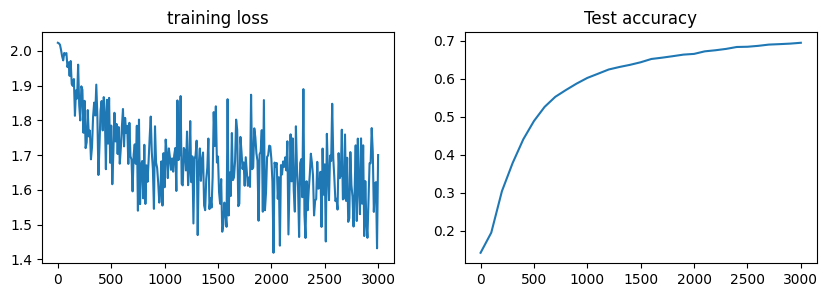

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize = (10,3))

x1 = np.arange(len(store_loss))*interval_loss
x2 = np.arange(len(store_acc))*interval_acc

ax[0].plot(x1, store_loss)
ax[1].plot(x2, store_acc)
ax[0].set_title('training loss')
ax[1].set_title('Test accuracy')

In [10]:
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components = 2, method='exact').fit_transform(h.detach().cpu().numpy())
    print(z.shape)
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

(500, 2)


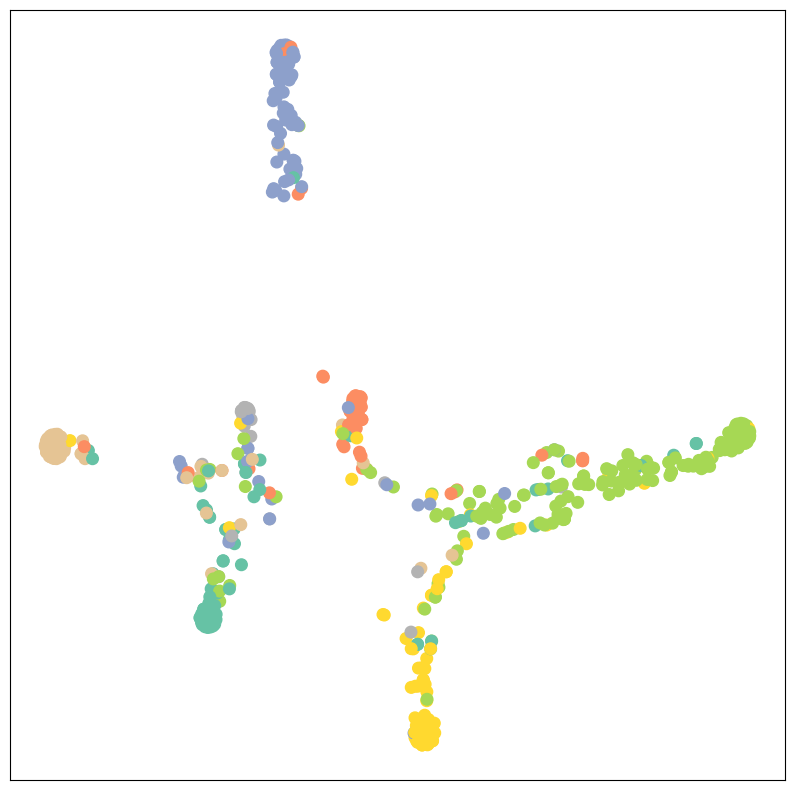

In [11]:
with torch.no_grad():
    A = torch.tensor(A_vali.todense()).to(device)
    H = H_vali.to(device)
    out = model(A, H).squeeze(1)
    visualize(out[:500], y_vali[:500])

# Masked Cross Entropy Loss loss (**DISREGARD. JUST USE PREMADE VERSION**):
for a row of $H_i$ and $P_i$, if $H_{i,k}$ is true solution since only $P_{i,k} = 1$, then
$$L_i=
-Log\left(\frac{exp(H_{i,k})}{\sum_j exp(H_{i,j})}\right) = -Log\left(\frac{a_i}{b_i}\right) 
$$

1. calc $exp(H_{i,j}) = H_{i,j}^e $

2. calc $H_{i,k}^e = a_i$
$$H_{i,k}^e = sum(H_i^e \otimes P_i) = 
sum(\begin{bmatrix}
H_{i,1}^e  & \dots & H_{i,k}^e & \dots
\end{bmatrix}\otimes
\begin{bmatrix}
0 & \dots & P_{i,k} = 1 & \dots
\end{bmatrix}
)=
0 H_{i,1}^e  + \dots + 1 H_{i,k}^e + \dots = H_{i,k}^e
$$

3. calc $\sum_j exp(H_{i,j}) = \sum_j H_{i,j}^e = b_i$

$$L_i = -Log\left(\frac{sum(H_i^e \otimes P_i)}{sum(H_i^e)}\right) $$

For a matrices $H$, $L$ and $P$

$$ L = -Log\left(\frac{sum(H^e \otimes P, dim = 1)}{sum(H^e, dim = 1)}\right) $$

4. reduce to a scalar
    * $sum(L)$ 
    * $mean(L)$

In [12]:
class MaskedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(MaskedCrossEntropyLoss, self).__init__()

    def forward(self, H, Y, mask):
        Hexp = torch.exp(H[mask])
        Hexp_norms = Hexp.sum(dim = 1)
        loss = - torch.log((H[mask] * Y[mask]).sum(dim = 1)/Hexp_norms)
        return loss
    
MCEL = MaskedCrossEntropyLoss()
torch.manual_seed(69)
idx = torch.randint(0,4,size = (5,));
Ps = torch.zeros(size = (5,4))
Ps[range(5),idx] = 1 ; Ps
data = torch.arange(torch.prod(torch.tensor(Ps.shape))).reshape(Ps.shape)

MCEL(data, Ps, torch.arange(5)).mean()

tensor(9.3532)